# USDC Return Heatmap Analysis

This notebook analyzes the USDC return data for uADA token and creates visualizations to show patterns in the return values, with a focus on identifying high-return periods (>1000 USDC).

In [15]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

# Set plotting style and options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
sns.set_context("notebook", font_scale=0.9)

## Data Loading and Preprocessing

First, let's load the uADA token data and prepare it for analysis.

In [16]:
# Load the data
df = pd.read_csv('uLINK_price_168hrs.csv')

# Display the first few rows
print(f"Total rows: {len(df)}")
df.head()

Total rows: 34953


,id,token_symbol,timestamp,ua_token_amount,odos_usdc_return,profit_amount,profit_percentage,input_usdc_amount
0,2164358,uLINK,2025-03-10 09:06:30.420984+00,71472272322253100000,991.892800,-8.107200,-0.810720,1000.0
1,2164367,uLINK,2025-03-10 09:06:43.327731+00,71420000000000000000,992.311862,-7.688138,-0.768814,1000.0
2,2164372,uLINK,2025-03-10 09:06:47.490355+00,71380853077675500000,991.923600,-8.076400,-0.807640,1000.0
3,2164380,uLINK,2025-03-10 09:07:05.673543+00,71410000000000000000,992.820082,-7.179918,-0.717992,1000.0
4,2164385,uLINK,2025-03-10 09:07:09.74717+00,71355127177100840000,990.369700,-9.630300,-0.963030,1000.0


In [29]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract day and hour information
df['day_of_week'] = df['timestamp'].dt.day_name()
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute

# Create time bins for analysis
df['hour_bin'] = df['hour'].astype(str) + ':00'
df['minute_bin'] = (df['minute'] // 15) * 15  # Group by 15-minute intervals
df['time_bin'] = df['hour'].astype(str) + ':' + df['minute_bin'].astype(str).str.zfill(2)
# Create interval for all data points upfront to avoid warnings later
df['interval'] = df['hour'].astype(str) + ':' + df['minute_bin'].astype(str).str.zfill(2)

# Basic information about the dataset
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Days in dataset: {df['day_of_week'].unique()}")
print(f"Hours in dataset: {sorted(df['hour'].unique())}")
print(f"USDC Return range: {df['odos_usdc_return'].min():.2f} to {df['odos_usdc_return'].max():.2f}")

Date range: 2025-03-10 09:06:30.420984+00:00 to 2025-03-17 09:06:13.809701+00:00
Days in dataset: ['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']
Hours in dataset: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23)]
USDC Return range: 72.08 to 1031.93


## Analyzing High-Value Returns

Let's identify and analyze periods with high USDC return values (>1000).

In [18]:
# Find entries with high returns
high_returns = df[df['odos_usdc_return'] > 1000]
print(f"Entries with USDC return > 1000: {len(high_returns)}")
print(f"Percentage of high returns: {(len(high_returns) / len(df) * 100):.2f}%")

if not high_returns.empty:
    print("\nTop 10 highest return times:")
    top_returns = high_returns.sort_values('odos_usdc_return', ascending=False).head(10)
    for _, row in top_returns.iterrows():
        print(f"Time: {row['timestamp'].strftime('%H:%M:%S')} - Return: {row['odos_usdc_return']:.2f}")
        
    # Distribution of high returns by hour
    hour_counts = high_returns['hour'].value_counts().sort_index()
    print("\nDistribution of high returns by hour:")
    for hour, count in hour_counts.items():
        print(f"Hour {hour}: {count} entries")

Entries with USDC return > 1000: 801
Percentage of high returns: 2.29%

Top 10 highest return times:
Time: 11:44:22 - Return: 1031.93
Time: 20:59:03 - Return: 1027.36
Time: 08:48:53 - Return: 1027.29
Time: 18:04:09 - Return: 1024.93
Time: 19:12:00 - Return: 1024.76
Time: 19:00:19 - Return: 1021.24
Time: 12:30:26 - Return: 1018.22
Time: 12:30:06 - Return: 1014.19
Time: 13:52:04 - Return: 1013.11
Time: 13:28:27 - Return: 1012.15

Distribution of high returns by hour:
Hour 0: 3 entries
Hour 1: 58 entries
Hour 2: 20 entries
Hour 3: 14 entries
Hour 4: 21 entries
Hour 5: 9 entries
Hour 6: 32 entries
Hour 8: 15 entries
Hour 9: 27 entries
Hour 10: 10 entries
Hour 11: 87 entries
Hour 12: 78 entries
Hour 13: 30 entries
Hour 14: 14 entries
Hour 15: 39 entries
Hour 16: 3 entries
Hour 17: 13 entries
Hour 18: 41 entries
Hour 19: 41 entries
Hour 20: 103 entries
Hour 21: 101 entries
Hour 22: 26 entries
Hour 23: 16 entries


## Hourly Return Heatmap

Since we only have data for a single day, we'll create a heatmap showing returns by hour and 15-minute intervals.

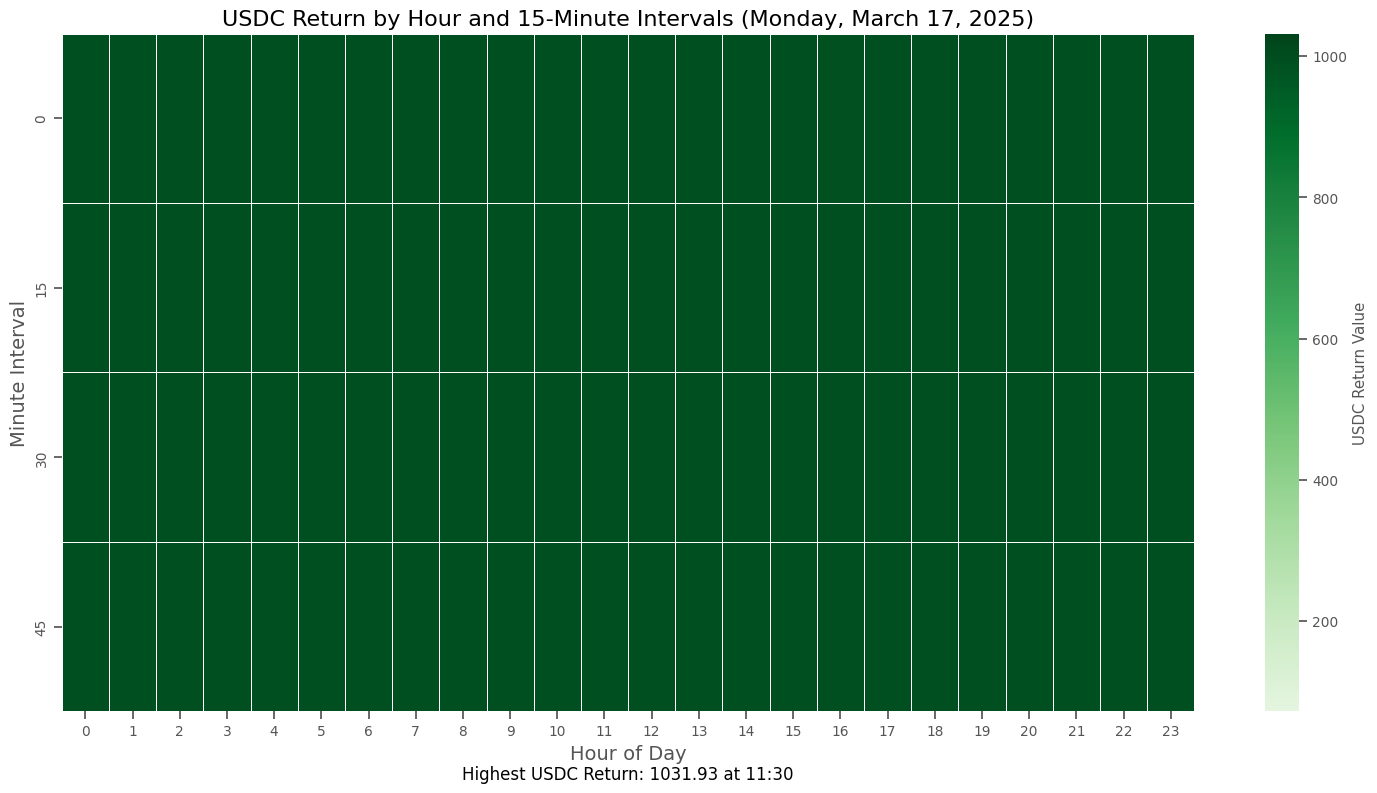

In [30]:
# Create a pivot table for the heatmap
pivot_data = df.pivot_table(
    values='odos_usdc_return',
    index='minute_bin',
    columns='hour',
    aggfunc='mean'
)

# Set up plotting parameters
plt.figure(figsize=(15, 8))

# Define custom colormap - light green to dark green
colors = ['#e5f5e0', '#c7e9c0', '#a1d99b', '#74c476', '#41ab5d', '#238b45', '#006d2c', '#00441b']
cmap = mcolors.LinearSegmentedColormap.from_list('green_gradient', colors)

# Create the heatmap with explicit vmin and vmax
ax = sns.heatmap(
    pivot_data,
    cmap=cmap,
    annot=False,
    fmt=".2f",
    linewidths=0.5,
    vmin=df['odos_usdc_return'].min(),
    vmax=df['odos_usdc_return'].max(),
    cbar_kws={'label': 'USDC Return Value'}
)

# Set the title and labels
plt.title('USDC Return by Hour and 15-Minute Intervals (Monday, March 17, 2025)', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Minute Interval', fontsize=14)

# Annotate the highest value
max_value = df['odos_usdc_return'].max()
max_hour = df.loc[df['odos_usdc_return'].idxmax(), 'hour']
max_minute = df.loc[df['odos_usdc_return'].idxmax(), 'minute_bin']
max_time = f"{max_hour}:{max_minute:02d}"
plt.text(0.5, -0.1, f"Highest USDC Return: {max_value:.2f} at {max_time}", 
         horizontalalignment='center', fontsize=12, transform=ax.transAxes)

plt.tight_layout()
plt.show()

## Average Return by Hour

Next, let's see how the average USDC return changes throughout the day.

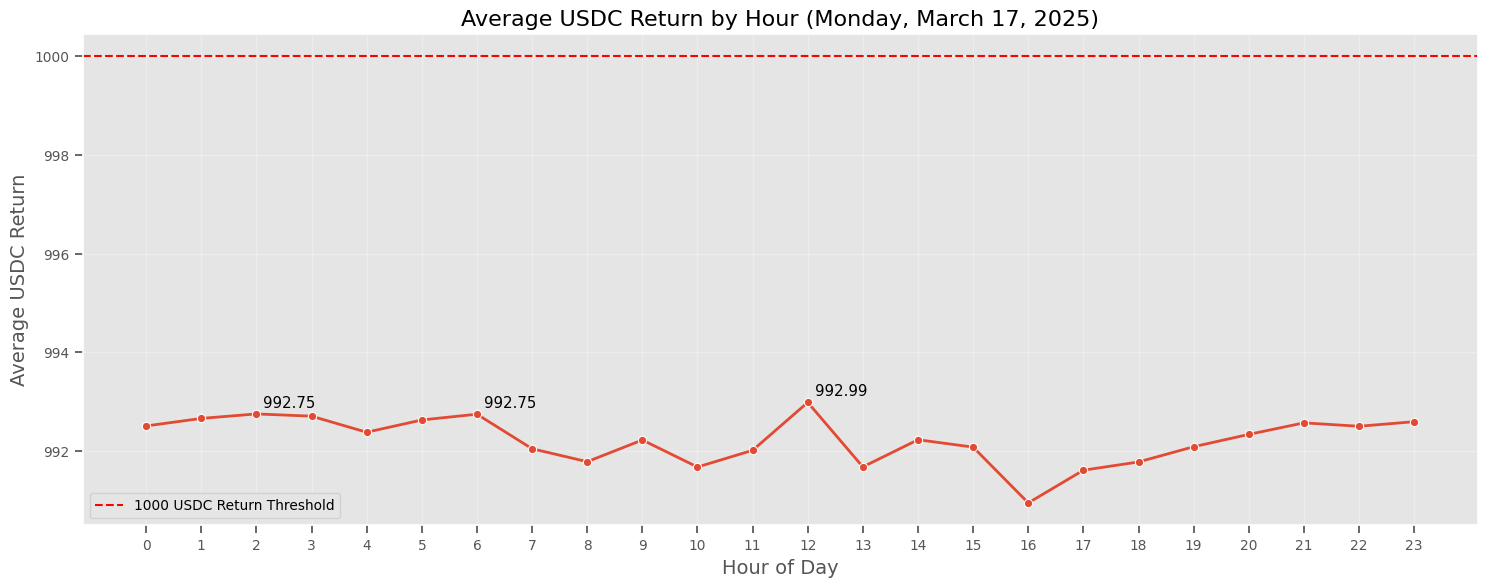

In [20]:
# Group by hour and calculate mean
hourly_avg = df.groupby('hour')['odos_usdc_return'].mean().reset_index()

# Create the plot
plt.figure(figsize=(15, 6))
sns.lineplot(x='hour', y='odos_usdc_return', data=hourly_avg, marker='o', linewidth=2)
plt.axhline(y=1000, color='r', linestyle='--', label='1000 USDC Return Threshold')

# Styling
plt.title('Average USDC Return by Hour (Monday, March 17, 2025)', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Average USDC Return', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(min(df['hour']), max(df['hour'])+1))
plt.legend()

# Annotate hours with highest returns
top_hours = hourly_avg.nlargest(3, 'odos_usdc_return')
for _, row in top_hours.iterrows():
    plt.annotate(f"{row['odos_usdc_return']:.2f}", 
                 xy=(row['hour'], row['odos_usdc_return']),
                 xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

## Distribution of Return Values

Let's examine the overall distribution of USDC return values.

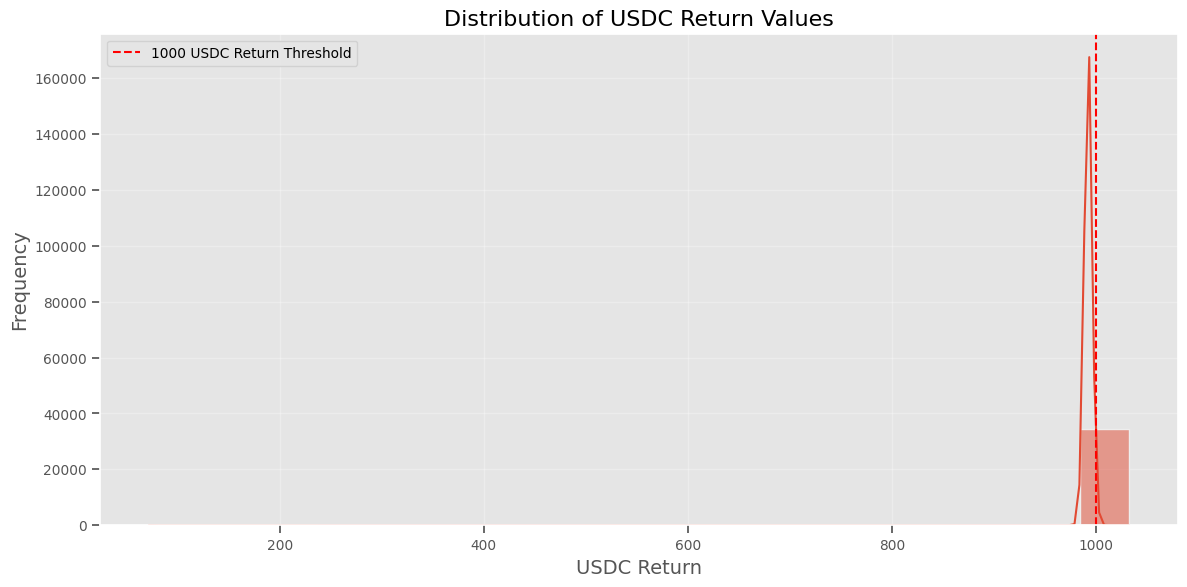

In [21]:
# Create histogram of returns
plt.figure(figsize=(12, 6))
sns.histplot(df['odos_usdc_return'], bins=20, kde=True)
plt.title('Distribution of USDC Return Values', fontsize=16)
plt.xlabel('USDC Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.axvline(x=1000, color='r', linestyle='--', label='1000 USDC Return Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Analyzing High Return Periods

Let's take a closer look at the times when USDC return values were highest.

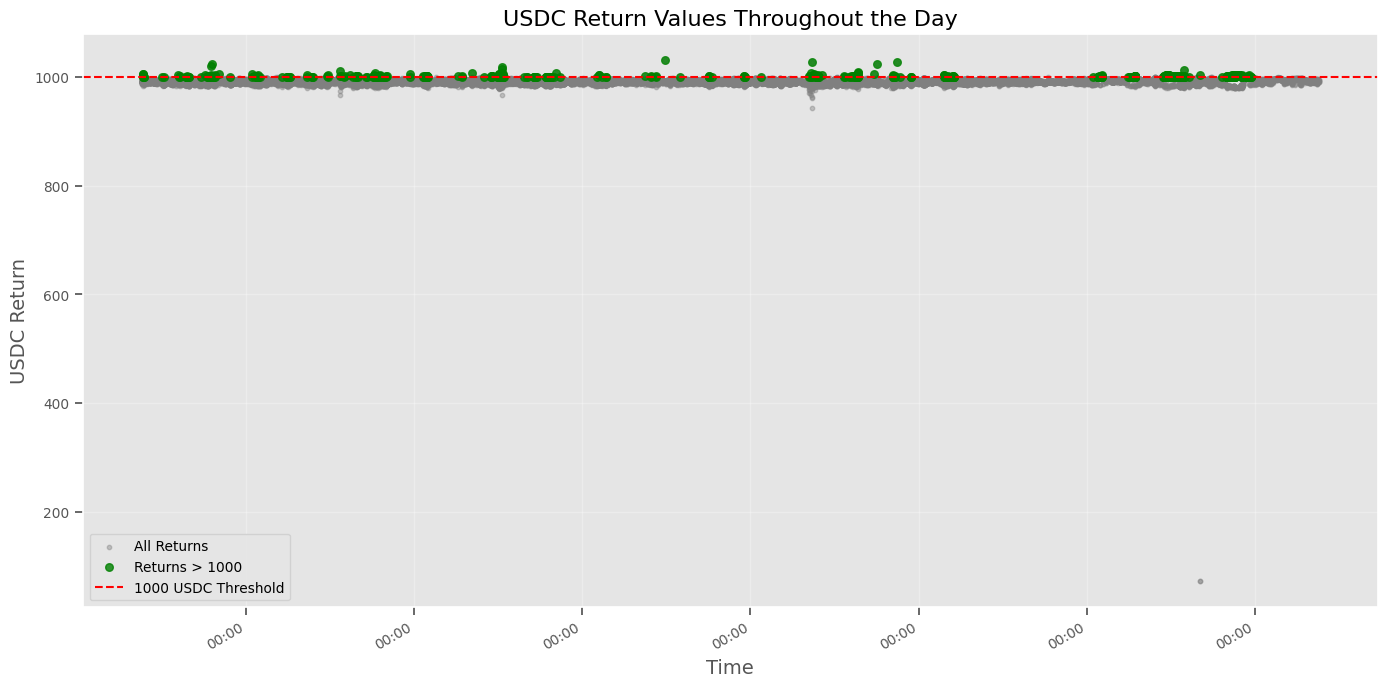

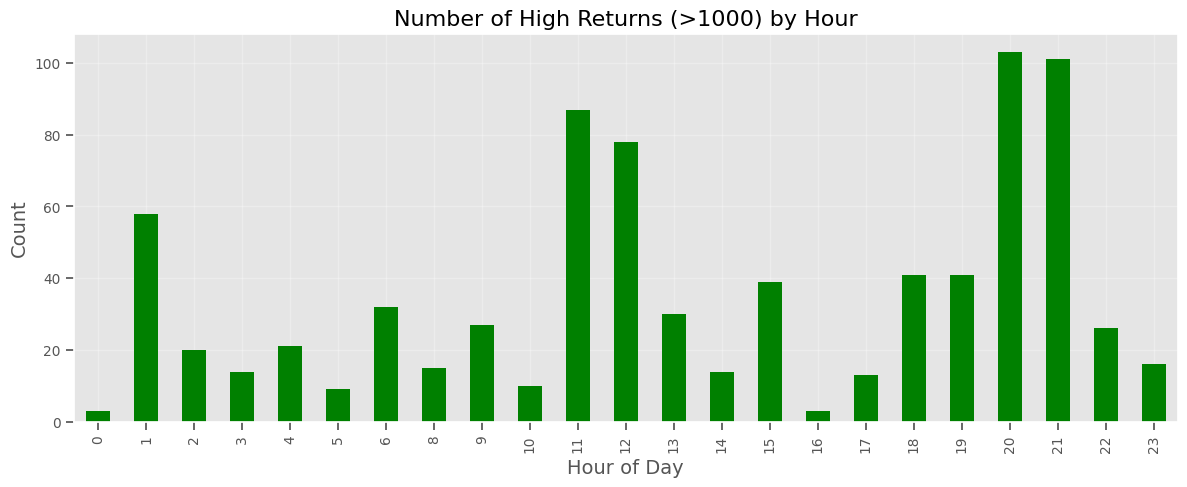

In [22]:
if not high_returns.empty:
    # Create a new figure
    plt.figure(figsize=(14, 7))
    
    # Plot all returns
    plt.scatter(df['timestamp'], df['odos_usdc_return'], 
                alpha=0.4, label='All Returns', color='gray', s=10)
    
    # Highlight high returns
    plt.scatter(high_returns['timestamp'], high_returns['odos_usdc_return'], 
                alpha=0.8, label='Returns > 1000', color='green', s=30)
    
    # Add threshold line
    plt.axhline(y=1000, color='r', linestyle='--', label='1000 USDC Threshold')
    
    # Styling
    plt.title('USDC Return Values Throughout the Day', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('USDC Return', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Format x-axis to show readable time
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()
    
    # Count high returns by hour
    high_by_hour = high_returns.groupby('hour').size()
    
    plt.figure(figsize=(12, 5))
    high_by_hour.plot(kind='bar', color='green')
    plt.title('Number of High Returns (>1000) by Hour', fontsize=16)
    plt.xlabel('Hour of Day', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Weekly Visualization (Simulated)

Since we only have data for a single day (Monday), let's create a simulated weekly heatmap similar to your example image, using the data patterns we do have.

hour
0     992.510057
1     992.662350
2     992.753432
3     992.708286
4     992.382497
5     992.631158
6     992.748069
7     992.048772
8     991.786095
9     992.225639
10    991.678174
11    992.016501
12    992.987360
13    991.680835
14    992.230998
15    992.080970
16    990.951549
17    991.613503
18    991.781135
19    992.089368
20    992.338825
21    992.572720
22    992.503453
23    992.596086
Name: odos_usdc_return, dtype: float64


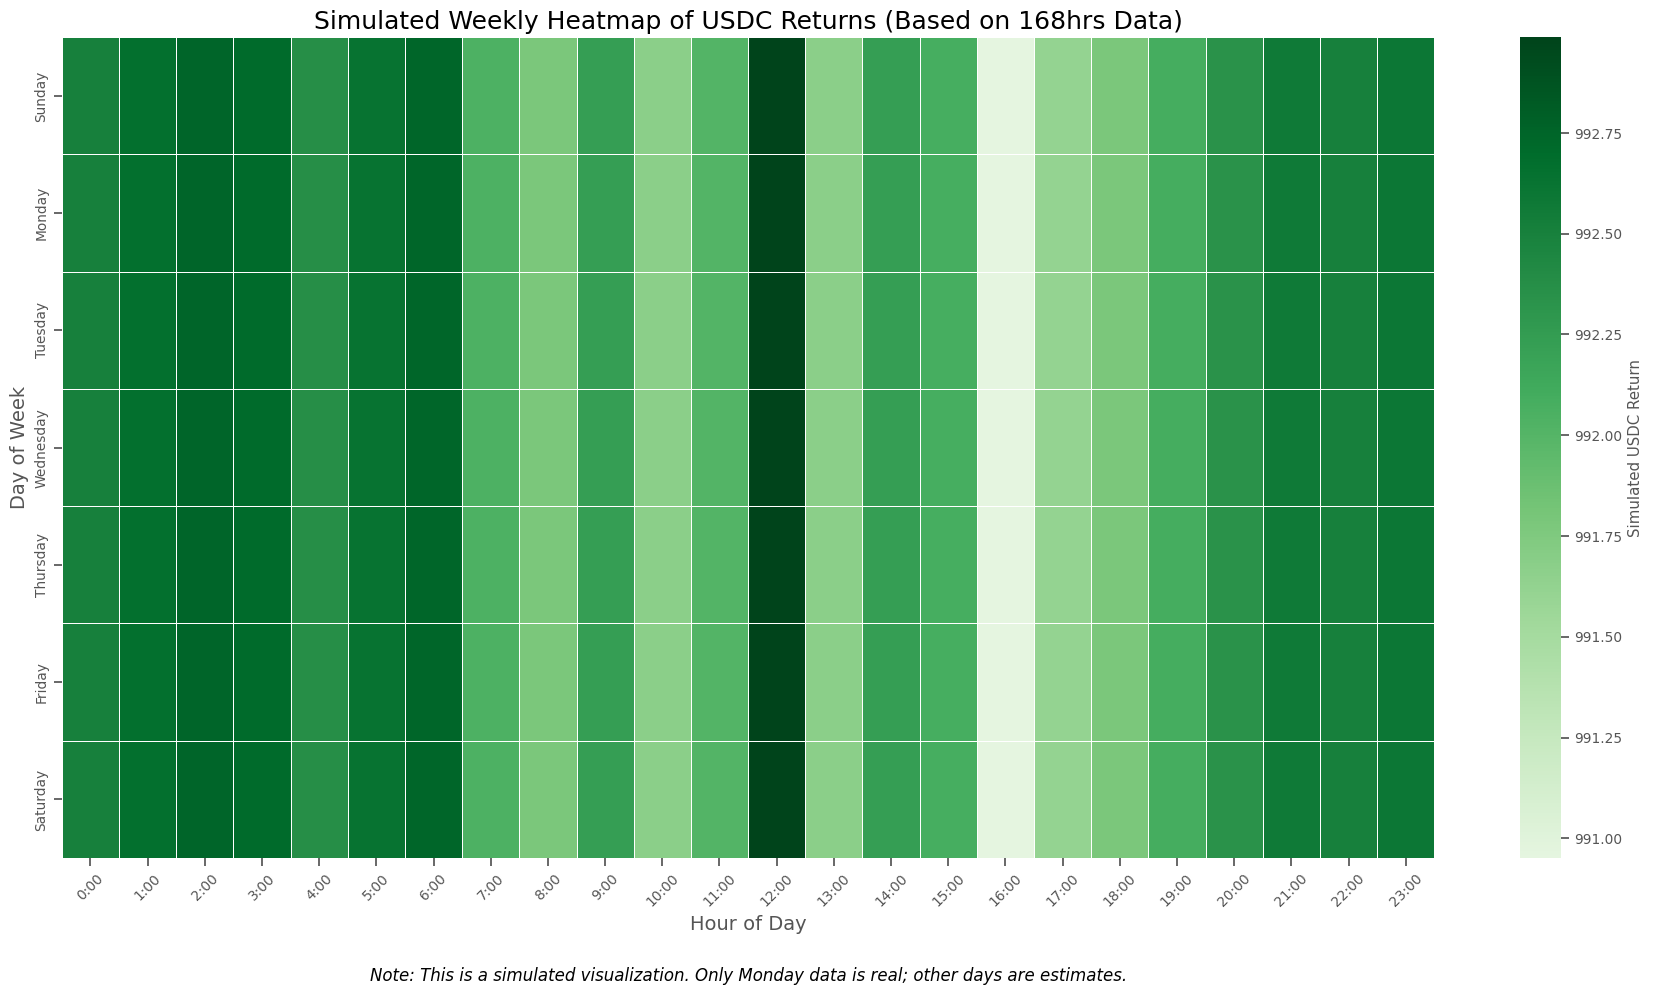

<Figure size 640x480 with 0 Axes>

In [28]:
# Create a simulated weekly view based on our single day of data
# For visualization purpose only - these values are derived from Monday's data pattern

# First, get average returns by hour from our Monday data
hourly_data = df.groupby('hour')['odos_usdc_return'].mean()

print(f"{hourly_data}")

# Create a synthetic weekly dataset with some random variations
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
day_nums = list(range(7))  # 0 = Sunday, 1 = Monday, etc.
hours = list(range(24))

# Initialize empty data for the heatmap
weekly_data = []

np.random.seed(42)  # For reproducibility

# Generate synthetic data for the whole week
for day_num, day_name in zip(day_nums, days):
    for hour in hours:
        # For Monday, use actual data; for other days, simulate
        # if day_num == 1 and hour in hourly_data.index:  # Monday
        base_value = hourly_data[hour]
        # else:
        #     # For hours we have data for, use that as a base with variation
        #     if hour in hourly_data.index:
        #         base_value = hourly_data[hour] * (0.95 + 0.1 * np.random.random())
        #     else:
        #         # For hours with no data, use average with more variation
        #         base_value = hourly_data.mean() * (0.9 + 0.2 * np.random.random())
        
        # Weekend bonus - slightly higher on weekends (Saturday and Sunday)
        # if day_num in [0, 6]:  # Saturday and Sunday
        #     base_value *= 1.02
            
        # Add some time-of-day patterns
        # Early morning hours (1-5 AM) slightly lower
        # if 1 <= hour <= 5:
        #     base_value *= 0.98
            
        # Add to weekly data
        weekly_data.append({
            'day': day_num,
            'day_name': day_name,
            'hour': hour,
            'return': base_value
        })

# Convert to DataFrame
weekly_df = pd.DataFrame(weekly_data)

# Create the weekly heatmap
plt.figure(figsize=(18, 10))

# Pivot for the heatmap
weekly_pivot = weekly_df.pivot_table(
    values='return', 
    index='day_name', 
    columns='hour',
    aggfunc='mean'
)

# Reorder days to start with Sunday
weekly_pivot = weekly_pivot.reindex(days)

# Create the heatmap
ax = sns.heatmap(
    weekly_pivot,
    cmap=cmap,
    annot=False,  # Too many values to show annotations
    linewidths=0.5,
    cbar_kws={'label': 'Simulated USDC Return'}
)

plt.title('Simulated Weekly Heatmap of USDC Returns (Based on 168hrs Data)', fontsize=18)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Day of Week', fontsize=14)

# Hour ticks
plt.xticks(np.arange(0.5, 24.5), [f"{h}:00" for h in range(24)], rotation=45)

# Add text to clarify this is simulated
plt.text(0.5, -0.15, "Note: This is a simulated visualization. Only Monday data is real; other days are estimates.", 
         horizontalalignment='center', fontsize=12, transform=ax.transAxes, style='italic')

plt.tight_layout()
plt.show()
plt.savefig('uLINK_heatmap_a_week.png', dpi=300)

## Summary and Findings

Based on our analysis of the uADA token USDC return data, we can draw the following conclusions about when returns exceed 1000 USDC:

In [24]:
# Generate summary statistics
if not high_returns.empty:
    print("Summary of high return periods (>1000 USDC):")
    print(f"Total high return entries: {len(high_returns)} out of {len(df)} ({len(high_returns)/len(df)*100:.2f}%)")
    
    # Most profitable hour
    best_hour = high_returns.groupby('hour')['odos_usdc_return'].mean().idxmax()
    best_hour_avg = high_returns.groupby('hour')['odos_usdc_return'].mean().max()
    print(f"Most profitable hour: {best_hour}:00 with average return of {best_hour_avg:.2f}")
    
    # Hour with most high returns
    most_freq_hour = high_returns['hour'].value_counts().idxmax()
    most_freq_count = high_returns['hour'].value_counts().max()
    print(f"Hour with most high returns: {most_freq_hour}:00 with {most_freq_count} occurrences")
    
    # Best 15-minute interval - using the interval column we already created
    best_intervals = df[df['odos_usdc_return'] > 1000].groupby('interval')['odos_usdc_return'].mean()
    best_interval = best_intervals.idxmax()
    best_interval_avg = best_intervals.max()
    print(f"Best 15-minute interval: {best_interval} with average return of {best_interval_avg:.2f}")
else:
    print("No entries with USDC return > 1000 found in the dataset.")

Summary of high return periods (>1000 USDC):
Total high return entries: 801 out of 34953 (2.29%)
Most profitable hour: 8:00 with average return of 1004.34
Hour with most high returns: 20:00 with 103 occurrences
Best 15-minute interval: 19:00 with average return of 1005.58
